In [25]:
# Data Set voorbereiden
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import pyodbc

DBAdventureWorks = {"servername": "localhost\SQLEXPRESS",
      "database": "AdventureWorks2019"}
DBaenc = {"servername": "localhost\SQLEXPRESS",
      "database": "aenc"}
DBNorthwind = {"servername": "localhost\SQLEXPRESS",
      "database": "Northwind"}


export_connAdventureWorks = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DBAdventureWorks['servername'] + 
                             ';DATABASE=' + DBAdventureWorks['database'] + ';Trusted_Connection=yes')
export_connaenc = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DBaenc['servername'] + 
                             ';DATABASE=' + DBaenc['database'] + ';Trusted_Connection=yes')
export_connNorthwind = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DBNorthwind['servername'] + 
                             ';DATABASE=' + DBNorthwind['database'] + ';Trusted_Connection=yes')

export_cursorAdventureWorks = export_connAdventureWorks.cursor()
export_cursoraenc = export_connaenc.cursor()
export_cursorNorthwind = export_connNorthwind.cursor()








# Historische verkoopdata selecteren

In [26]:
adventureworks_data = pd.read_sql_query("SELECT * FROM Sales.SalesOrderDetail;", export_connAdventureWorks)
AdventurWorksSalesOrderHeader = pd.read_sql_query("SELECT * FROM Sales.SalesOrderHeader", export_connAdventureWorks)
adventureworks_data = adventureworks_data.merge(AdventurWorksSalesOrderHeader, on='SalesOrderID')
adventureworks_data['Source'] = 'AdventureWorks2019'

aenc_data = pd.read_sql_query("SELECT * FROM sales_order_item",export_connaenc)
aenc_data = aenc_data.rename(columns={'prod_id': 'ProductID', 'quantity': 'OrderQty', 'ship_date': 'OrderDate'})
aenc_data['Source'] = 'aenc'

northwind_data = pd.read_sql_query("select * from dbo.[Order Details]",export_connNorthwind)
orders_data = pd.read_sql_query("SELECT * FROM Orders", export_connNorthwind)

northwind_data = northwind_data.merge(orders_data, on='OrderID')
northwind_data = northwind_data.rename(columns={'Quantity': 'OrderQty'})
northwind_data['Source'] = 'Northwind'


# Datasets combineren

In [27]:
combined_data = pd.concat([adventureworks_data[['ProductID', 'OrderQty', 'OrderDate', 'Source']], 
                           aenc_data[['ProductID', 'OrderQty', 'OrderDate', 'Source']], 
                           northwind_data[['ProductID', 'OrderQty', 'OrderDate', 'Source']]], ignore_index=True)

pd.set_option('display.max_rows',None)

combined_data['OrderQty'] = pd.to_numeric(combined_data['OrderQty'])


# Data voorbereiden

In [ ]:
# Verwijder missende waarden
combined_data.dropna(inplace=True)

# Converteer OrderDate naar datetime
combined_data['OrderDate'] = pd.to_datetime(combined_data['OrderDate'])

# Voeg extra features toe zoals jaar en maand
combined_data['Year'] = combined_data['OrderDate'].dt.year
combined_data['Month'] = combined_data['OrderDate'].dt.month

combined_data['OrderQty'] = pd.to_numeric(combined_data['OrderQty'])

combined_data['Season'] = combined_data['OrderDate'].dt.quarter

# Bereken de geaggregeerde sales per seizoen
seasonal_sales = combined_data.groupby(['Season']).agg({'OrderQty': 'sum'}).reset_index()

# Bereken verkoopvolume per productcategorie per maand
# aggregated_data = combined_data.groupby(['ProductID', 'Year', 'Month']).agg({'OrderQty': 'sum', 'Source': 'first'}).reset_index()
# aggregated_data.rename(columns={'OrderQty': 'TotalOrderQty'}, inplace=True)


combined_data['Season'] = combined_data['OrderDate'].dt.quarter

# Groepeer de gegevens op basis van 'Source', 'ProductID' en het seizoen
grouped_data = combined_data.groupby(['Source', 'ProductID', 'Season']).agg({'OrderQty': 'sum'}).reset_index()

grouped_data


# voorspelling: product per seizoen

In [51]:
# Dictionary om modellen op te slaan per product-ID
models = {}

# Voor elk uniek product-ID, train een regressiemodel
for product_id, group in grouped_data.groupby('ProductID'):
    X = group[['Season']]
    y = group['OrderQty']
    
    # Train een regressiemodel
    model = LinearRegression()
    model.fit(X, y)
    
    # Sla het model op in de dictionary
    models[product_id] = model

# Voorbeeld: Voorspel de verkoopcijfers voor een specifiek product-ID en seizoen
product_id = '300'
season = 1  # Voorbeeldseizoen

# Haal het relevante model op uit de dictionary
model = models.get(product_id)

if model:
    # Voorspel de verkoopcijfers voor het specifieke seizoen
    predicted_sales = model.predict([[season]])
    print("Voorspelde verkoopcijfers voor ProductID", product_id, "voor seizoen", season, ":", predicted_sales[0])
else:
    print("Geen model gevonden voor het opgegeven product-ID")

Voorspelde verkoopcijfers voor ProductID 300 voor seizoen 1 : 346.0


# visualiseren

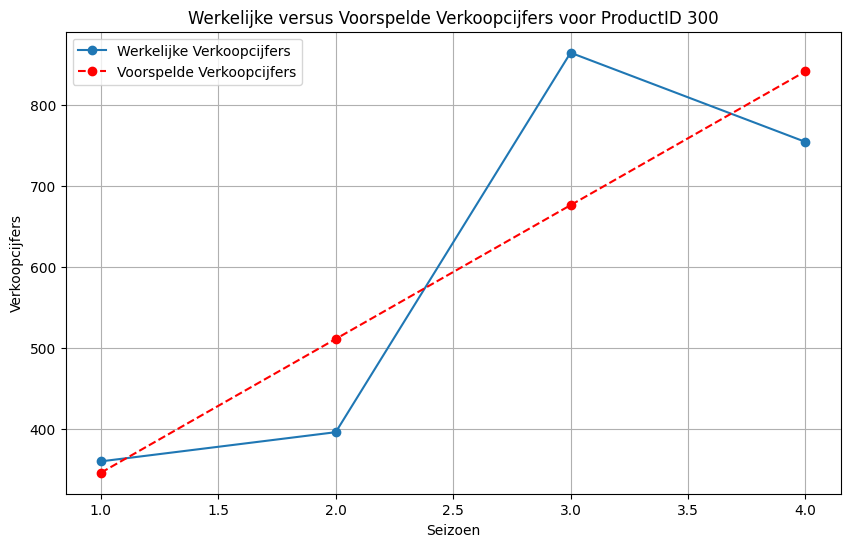

In [52]:
if model:
    # Voorspel de verkoopcijfers voor alle seizoenen
    seasons = range(1, 5)  # Aantal seizoenen aanpassen indien nodig
    predicted_sales = model.predict([[season] for season in seasons])

    # Haal de werkelijke verkoopcijfers op voor het product-ID
    actual_sales = grouped_data[grouped_data['ProductID'] == product_id]['OrderQty']

    # Plot de werkelijke versus voorspelde verkoopcijfers
    plt.figure(figsize=(10, 6))
    plt.plot(seasons, actual_sales, marker='o', label='Werkelijke Verkoopcijfers')
    plt.plot(seasons, predicted_sales, marker='o', linestyle='--', color='r', label='Voorspelde Verkoopcijfers')
    plt.xlabel('Seizoen')
    plt.ylabel('Verkoopcijfers')
    plt.title('Werkelijke versus Voorspelde Verkoopcijfers voor ProductID ' + product_id)
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Geen model gevonden voor het opgegeven product-ID")

# Data splitsen

alles hieronder klopt niet helemaal en kan waarschijnlijk weg (machine learning code klopt wel maar de data is nutteloos)

In [30]:
from sklearn.model_selection import train_test_split

X = aggregated_data[['ProductID', 'Year', 'Month']]
y = aggregated_data['TotalOrderQty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model trainen

In [31]:
from sklearn.linear_model import LinearRegression

# Train een lineair regressiemodel
model = LinearRegression()
model.fit(X_train, y_train)

# Voorspel op de testset
predictions = model.predict(X_test)

# resultaten evalueren

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 48.23815820925706
Root Mean Squared Error: 71.35668985096918


# Resultaten visualiseren

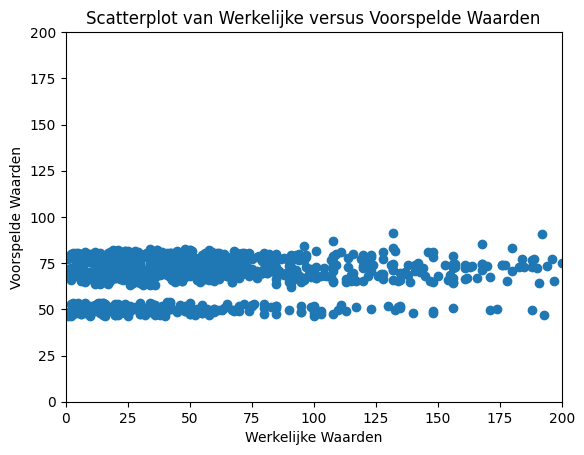

In [40]:
import matplotlib.pyplot as plt

plt.scatter(y_test, predictions)
plt.xlabel('Werkelijke Waarden')
plt.ylabel('Voorspelde Waarden')
plt.title('Scatterplot van Werkelijke versus Voorspelde Waarden')

max_value = 200
plt.xlim(0, max_value)
plt.ylim(0, max_value)
plt.show()
